In [2]:
import sys
import os

# Get the absolute path of the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Add it to sys.path if not already added
if project_root not in sys.path:
    sys.path.append(project_root)

Distribution created with:
Number of Samples: 10000
Number of Features: 20
Skewness: 0
Kurtosis Change: False
Bimodality: False


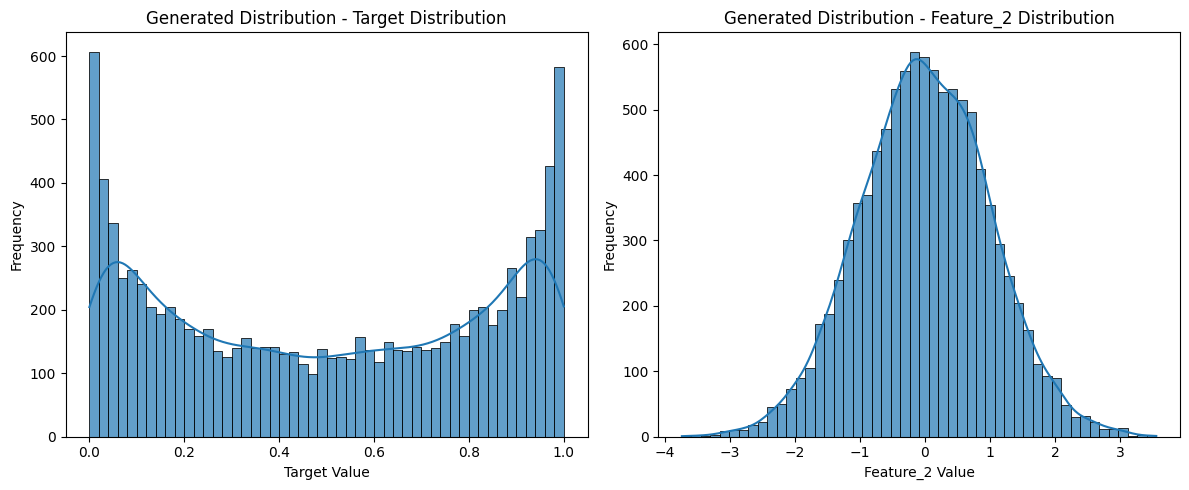

Metrics for Generated Distribution:
Mean: 0.0000
Standard Deviation: 1.0001
Skewness: -0.0053
Kurtosis: 0.0109

--------------------------------------------------



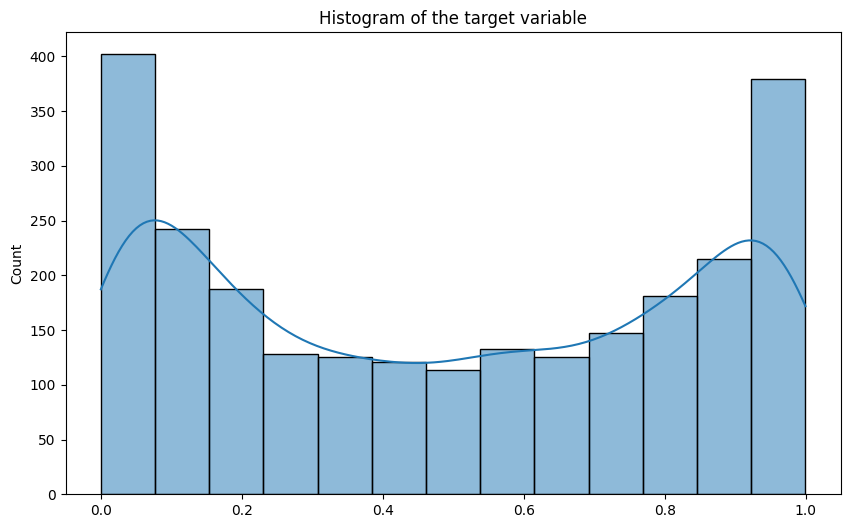

Train set size: 2500
Test set size: 2250
Calibration set size: 250
Train+Calibration set size: 2750


In [28]:
from src.main import Main

# Parameters for data generation
df_params = {
    'N': 10000,
    'F': 20,
    'skewness': 0,
    'kurtosis_change': False,
    'kurtosis_scale': 0,
    'mixture': False,
    'bimodal_separation': 15,
    'scaled': True,
}

# Utility values for decision outcomes
utility_dict = {
    'tp': 10,
    'tn': 2,
    'fp': -1,
    'fn': -8,
}

# Size of subset to be drawn from dataset
subset_size = 5000

# Confidence level
epsilon = 0.05

# Data split ratios for training, testing, and calibration
datasplit_dict = {
    'train_test': 0.5,  # XX% of data initially goes to test+calibration
    'test_cal': 0.9,    # XX% of data goes to test
}

config_dict = {
    'mode': "Online",
    'knn': True,
    'ridge': True,
    'gp': True,
    'bayesian_ridge': True,
    'optimal': True,
    'predictive': False
}

# Instantiate and run Main class
main = Main(df_params, utility_dict, subset_size, epsilon, datasplit_dict, config_dict)
splits = main.data_generation()



In [29]:
X_train = splits["X_train_full"]
y_train = splits["y_train_full"]
X_test = splits["X_test"]
y_test = splits["y_test"]

In [30]:
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# ---- Ridge Regression ----
ridge_model = Ridge(alpha=1.0)  # alpha is the regularization strength
ridge_model.fit(X_train, y_train)
ridge_preds = ridge_model.predict(X_test)

print("Ridge Regression Results:")
print("MSE:", mean_squared_error(y_test, ridge_preds))
print()

# ---- K-Nearest Neighbors ----
knn_model = KNeighborsRegressor(n_neighbors=10)
knn_model.fit(X_train, y_train)
knn_preds = knn_model.predict(X_test)

print("KNN Regression Results:")
print("MSE:", mean_squared_error(y_test, knn_preds))


Ridge Regression Results:
MSE: 0.012156856161288516

KNN Regression Results:
MSE: 0.03469424971505378


In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# Define the model
knn = KNeighborsRegressor()

# Define the parameter grid
param_grid = {
    'n_neighbors': list(range(1, 50)),  # Try k from 1 to 20
    'weights': ['uniform', 'distance'],  # Optional: try both weighting schemes
}

# Set up GridSearchCV
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best model and parameters
best_knn = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

# Predict and evaluate
knn_preds = best_knn.predict(X_test)
print("Tuned KNN Results:")
print("MSE:", mean_squared_error(y_test, knn_preds))



Best parameters: {'n_neighbors': 14, 'weights': 'distance'}
Tuned KNN Results:
MSE: 0.03477742964198812


In [32]:
knn_model = KNeighborsRegressor(**grid_search.best_params_)
knn_model.fit(X_train, y_train)

knn_preds = knn_model.predict(X_test)

print("KNN Regression Results:")
print("MSE:", mean_squared_error(y_test, knn_preds))

KNN Regression Results:
MSE: 0.03477742964198812


In [33]:
import numpy as np
from sklearn.linear_model import BayesianRidge
from sklearn.datasets import make_regression

# Generate first dataset
X1, y1 = make_regression(n_samples=30, n_features=5, noise=10, random_state=1)

# Generate second dataset (different noise)
X2, y2 = make_regression(n_samples=30, n_features=5, noise=50, random_state=2)

# Fit Bayesian Ridge on first dataset
model1 = BayesianRidge()
model1.fit(X1, y1)

# Fit Bayesian Ridge on second dataset
model2 = BayesianRidge()
model2.fit(X2, y2)

# Print the learned hyperparameters
print("=== Model 1 (low noise) ===")
print("Estimated alpha:", model1.alpha_)
print("Estimated lambda:", model1.lambda_)
print()

print("=== Model 2 (high noise) ===")
print("Estimated alpha:", model2.alpha_)
print("Estimated lambda:", model2.lambda_)


=== Model 1 (low noise) ===
Estimated alpha: 0.011872686147461583
Estimated lambda: 0.0002535900716455595

=== Model 2 (high noise) ===
Estimated alpha: 0.00051410788288018
Estimated lambda: 0.00022661511823377864


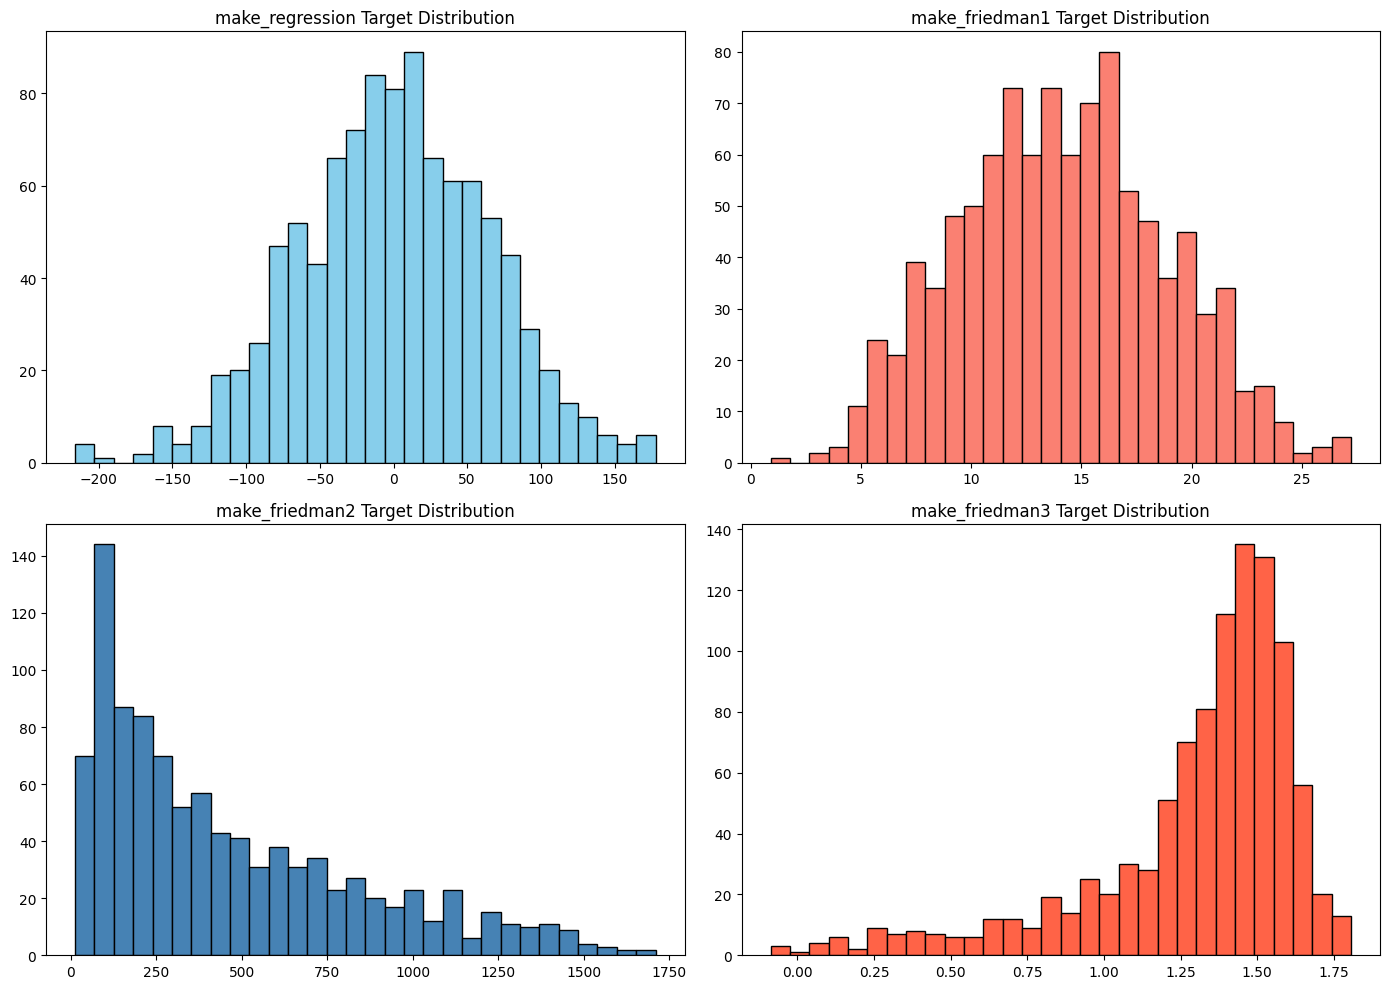

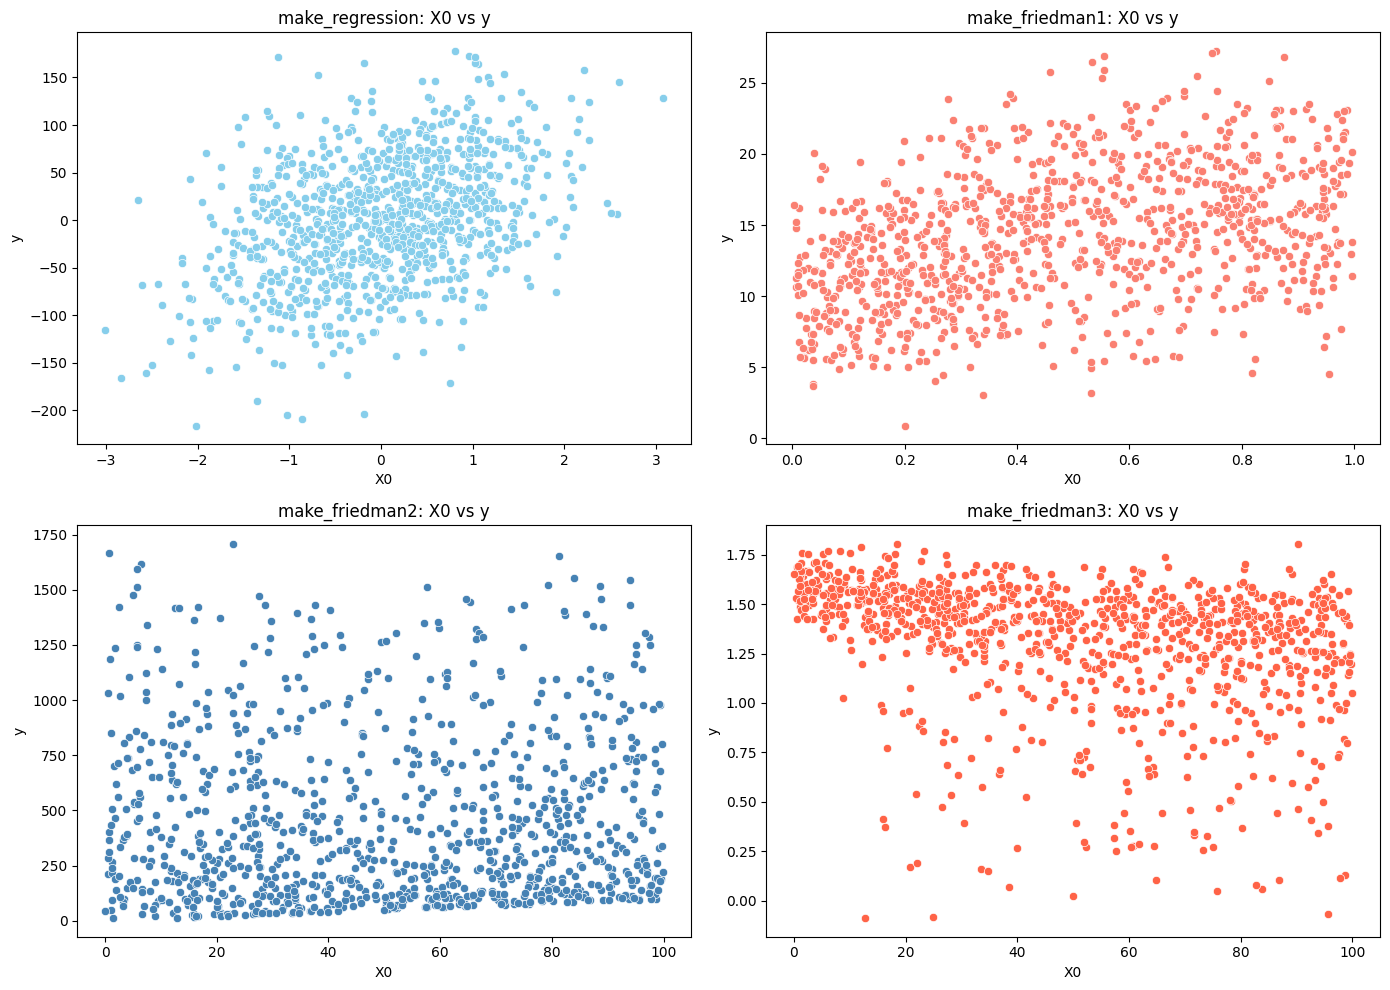

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_regression, make_friedman1, make_friedman2, make_friedman3

# Set seed for reproducibility
np.random.seed(42)

# Generate datasets
X_reg, y_reg = make_regression(n_samples=1000, n_features=5, n_informative=5, noise=10.0, random_state=42)
X_f1, y_f1 = make_friedman1(n_samples=1000, noise=0.1, random_state=42)
X_f2, y_f2 = make_friedman2(n_samples=1000, noise=0.1, random_state=42)
X_f3, y_f3 = make_friedman3(n_samples=1000, noise=0.1, random_state=42)

# Convert to DataFrames for ease of use
df_reg = pd.DataFrame(X_reg, columns=[f"X{i}" for i in range(X_reg.shape[1])])
df_reg["y"] = y_reg

df_f1 = pd.DataFrame(X_f1, columns=[f"X{i}" for i in range(X_f1.shape[1])])
df_f1["y"] = y_f1

df_f2 = pd.DataFrame(X_f2, columns=[f"X{i}" for i in range(X_f2.shape[1])])
df_f2["y"] = y_f2

df_f3 = pd.DataFrame(X_f3, columns=[f"X{i}" for i in range(X_f3.shape[1])])
df_f3["y"] = y_f3

# Plot target histograms
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs[0, 0].hist(df_reg['y'], bins=30, color='skyblue', edgecolor='black')
axs[0, 0].set_title("make_regression Target Distribution")

axs[0, 1].hist(df_f1['y'], bins=30, color='salmon', edgecolor='black')
axs[0, 1].set_title("make_friedman1 Target Distribution")

axs[1, 0].hist(df_f2['y'], bins=30, color='steelblue', edgecolor='black')
axs[1, 0].set_title("make_friedman2 Target Distribution")

axs[1, 1].hist(df_f3['y'], bins=30, color='tomato', edgecolor='black')
axs[1, 1].set_title("make_friedman3 Target Distribution")

plt.tight_layout()
plt.show()

# Plot feature-target relationships for feature X0
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

sns.scatterplot(x="X0", y="y", data=df_reg, ax=axs[0, 0], color='skyblue')
axs[0, 0].set_title("make_regression: X0 vs y")

sns.scatterplot(x="X0", y="y", data=df_f1, ax=axs[0, 1], color='salmon')
axs[0, 1].set_title("make_friedman1: X0 vs y")

sns.scatterplot(x="X0", y="y", data=df_f2, ax=axs[1, 0], color='steelblue')
axs[1, 0].set_title("make_friedman2: X0 vs y")

sns.scatterplot(x="X0", y="y", data=df_f3, ax=axs[1, 1], color='tomato')
axs[1, 1].set_title("make_friedman3: X0 vs y")

plt.tight_layout()
plt.show()


In [48]:

def generate_data(generator, N, F, **kwargs):
    """
    Generates data using the specified generator function.
    
    Parameters:
    - generator: Function that generates random data.
    - N: Number of samples.
    - F: Number of features.
    - kwargs: Additional arguments for the generator function.
    
    Returns:
    - Generated data as a NumPy array.
    """
    return generator(size=(N, F), **kwargs)

# Example with uniform distribution
data_uniform = generate_data(np.random.uniform, 1000, 5, low=0.0, high=1.0)
print("Uniform data shape:", data_uniform.shape)

# Example with normal (Gaussian) distribution
data_normal = generate_data(np.random.normal, 1000, 5, loc=0.0, scale=1.0)
print("Normal data shape:", data_normal.shape)

Uniform data shape: (1000, 5)
Normal data shape: (1000, 5)


In [62]:
def friedman1_scaled(X, noise_std=1.0, random_state=2025):
    """
    Compute the Friedman function with optional Gaussian noise and scale the output to [0, 1].
    
    Parameters:
    - X: numpy array of shape (n_samples, n_features), must have at least 5 columns
    - noise_std: standard deviation of the Gaussian noise added to the target
    - random_state: int or None, for reproducibility
    
    Returns:
    - y_scaled: target values scaled to [0, 1]
    """
    assert X.shape[1] >= 5, "Friedman function requires at least 5 features"

    rng = np.random.default_rng(random_state)

    x1, x2, x3, x4, x5 = X[:, 0], X[:, 1], X[:, 2], X[:, 3], X[:, 4]
    y = (
        10 * np.sin(np.pi * x1 * x2)
        + 20 * (x3 - 0.5) ** 2
        + 10 * x4
        + 5 * x5
        + rng.normal(loc=0.0, scale=noise_std, size=X.shape[0])
    )

    # Scale to [0, 1]
    y_scaled = (y - y.min()) / (y.max() - y.min())

    return y_scaled

def friedman2_scaled(X, noise_std=1.0, random_state=2025):
    """
    Compute the Friedman2 function with optional Gaussian noise and scale to [0, 1].
    Requires 4 features.
    """
    assert X.shape[1] >= 4, "Friedman2 function requires at least 4 features"
    rng = np.random.default_rng(random_state)
    
    x1, x2, x3, x4 = X[:, 0], X[:, 1], X[:, 2], X[:, 3]
    term = (x2 * x3 - 1 / (x2 * x4))
    y = np.sqrt(x1**2 + term**2)
    y += rng.normal(loc=0.0, scale=noise_std, size=X.shape[0])
    
    y_scaled = (y - y.min()) / (y.max() - y.min())
    return y_scaled

def friedman3_scaled(X, noise_std=1.0, random_state=2025):
    """
    Compute the Friedman3 function with optional Gaussian noise and scale to [0, 1].
    Requires 4 features.
    """
    assert X.shape[1] >= 4, "Friedman3 function requires at least 4 features"
    rng = np.random.default_rng(random_state)
    
    x1, x2, x3, x4 = X[:, 0], X[:, 1], X[:, 2], X[:, 3]
    numerator = x2 * x3 - 1 / (x2 * x4)
    y = np.arctan(numerator / x1)
    y += rng.normal(loc=0.0, scale=noise_std, size=X.shape[0])
    
    y_scaled = (y - y.min()) / (y.max() - y.min())
    return y_scaled

In [63]:
y_1 = friedman1_scaled(data_uniform)
y_2 = friedman2_scaled(data_uniform)
y_3 = friedman3_scaled(data_uniform)

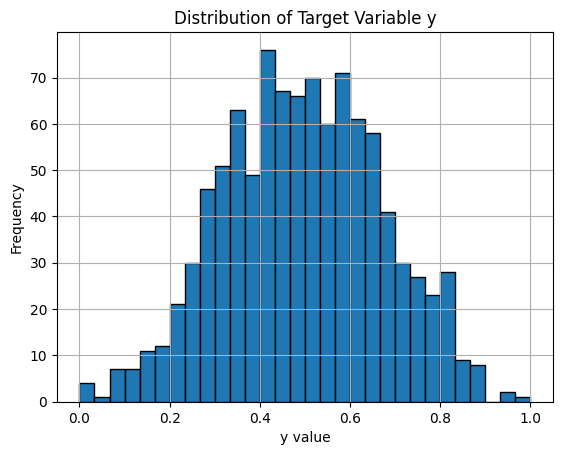

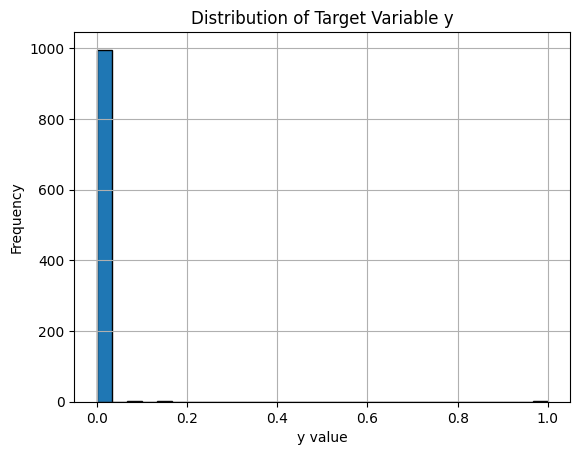

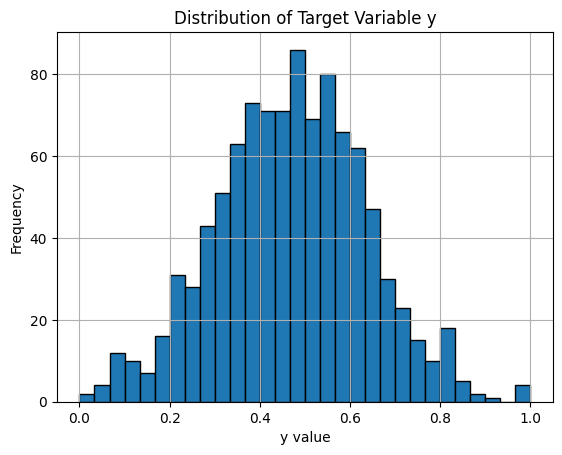

In [64]:
import matplotlib.pyplot as plt

# Assuming y is already generated
# y = friedman1_scaled(data_normal)

plt.hist(y_1, bins=30, edgecolor='black')
plt.title('Distribution of Target Variable y')
plt.xlabel('y value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

plt.hist(y_2, bins=30, edgecolor='black')
plt.title('Distribution of Target Variable y')
plt.xlabel('y value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

plt.hist(y_3, bins=30, edgecolor='black')
plt.title('Distribution of Target Variable y')
plt.xlabel('y value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

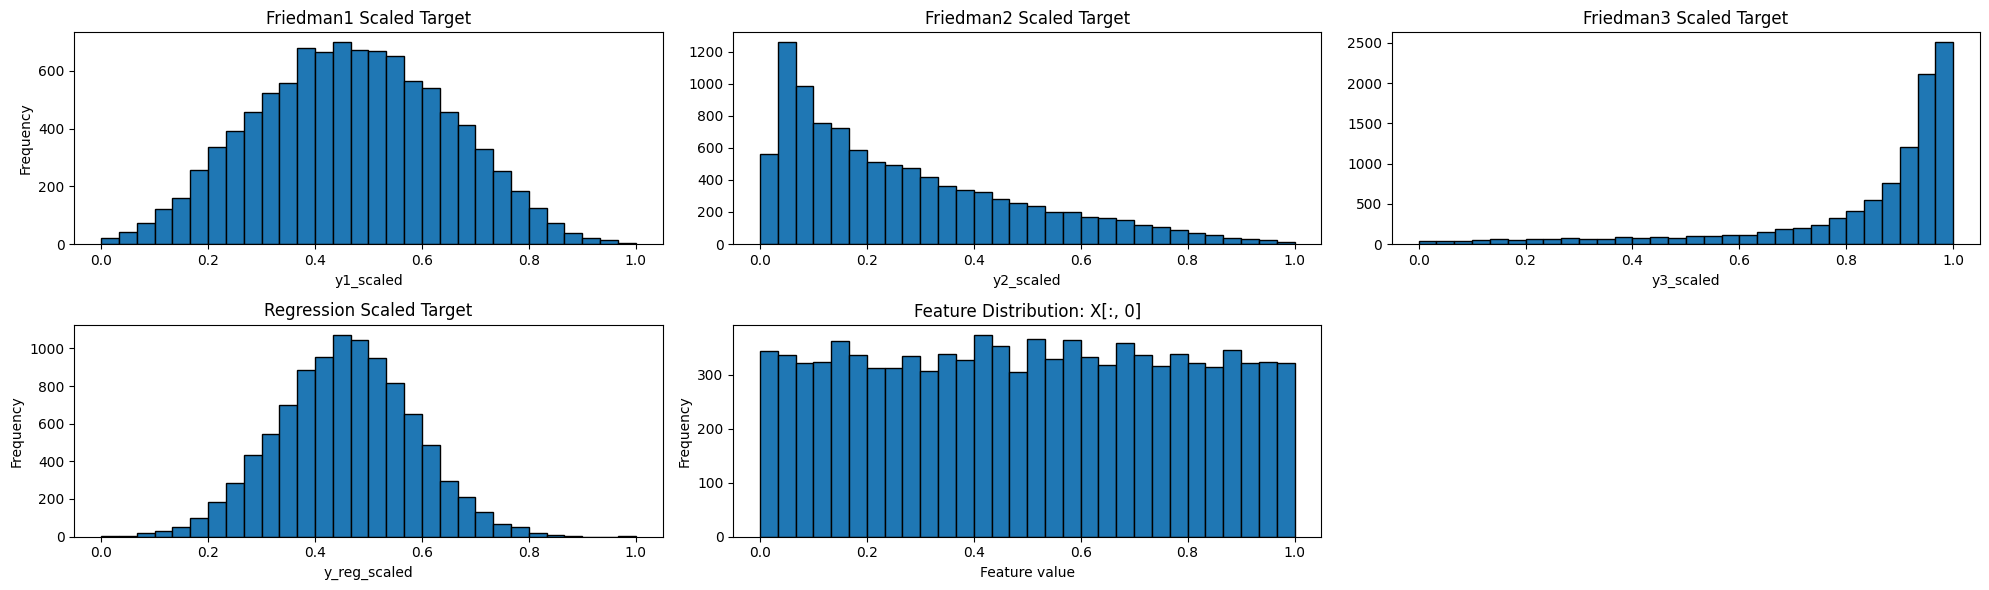

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_friedman1, make_friedman2, make_friedman3, make_regression
from sklearn.preprocessing import MinMaxScaler

# Parameters
N = 10000  # Number of samples
F = 10     # Number of features

# Generate input data (features)
X = np.random.rand(N, F)  # Uniformly distributed in [0, 1]

# Generate targets
_, y1 = make_friedman1(n_samples=N, n_features=F, noise=0.0, random_state=0)
_, y2 = make_friedman2(n_samples=N, noise=0.0, random_state=0)
_, y3 = make_friedman3(n_samples=N, noise=0.0, random_state=0)
_, y_reg = make_regression(n_samples=N, n_features=F, noise=0.0, random_state=0)

# Min-Max scaling
scaler = MinMaxScaler()
y1_scaled = scaler.fit_transform(y1.reshape(-1, 1)).ravel()
y2_scaled = scaler.fit_transform(y2.reshape(-1, 1)).ravel()
y3_scaled = scaler.fit_transform(y3.reshape(-1, 1)).ravel()
y_reg_scaled = scaler.fit_transform(y_reg.reshape(-1, 1)).ravel()

# Plot histograms
plt.figure(figsize=(20, 6))

plt.subplot(2, 3, 1)
plt.hist(y1_scaled, bins=30, edgecolor='black')
plt.title('Friedman1 Scaled Target')
plt.xlabel('y1_scaled')
plt.ylabel('Frequency')

plt.subplot(2, 3, 2)
plt.hist(y2_scaled, bins=30, edgecolor='black')
plt.title('Friedman2 Scaled Target')
plt.xlabel('y2_scaled')

plt.subplot(2, 3, 3)
plt.hist(y3_scaled, bins=30, edgecolor='black')
plt.title('Friedman3 Scaled Target')
plt.xlabel('y3_scaled')

plt.subplot(2, 3, 4)
plt.hist(y_reg_scaled, bins=30, edgecolor='black')
plt.title('Regression Scaled Target')
plt.xlabel('y_reg_scaled')
plt.ylabel('Frequency')

plt.subplot(2, 3, 5)
plt.hist(X[:, 0], bins=30, edgecolor='black')
plt.title('Feature Distribution: X[:, 0]')
plt.xlabel('Feature value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
